In [1]:
import numpy as np
import cv2
import math
import statistics as stat
from skimage.filters import threshold_otsu
from google.colab.patches import cv2_imshow
  
def apply_gamma(image, mean, std, gamma=2):
	invGamma = 1.0 / gamma
	table = np.array([(((i / 255.0) ** (invGamma)) * 255) if i < mean else (((i / 255.0) ** (1/1.8)) * 255)
		for i in np.arange(0, 256)]).astype("uint8")
	return cv2.LUT(image, table)

def gamma_correction(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  val = hsv[:,:,2]
  mean = np.mean(val)
  std = np.std(val)
  gamma = 2
  hsv[:,:,2] = apply_gamma(val, mean, std, gamma = gamma)
  final_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  return final_image

def BGR2c1c2c3(img):
  im = img.astype(np.float32)+0.001
  c1c2c3 = np.arctan(im/np.dstack((cv2.max(im[...,1], im[...,2]), cv2.max(im[...,0], im[...,2]), cv2.max(im[...,0], im[...,1]))))

  return c1c2c3

def shadow_detection(image):
  image_g = gamma_correction(image)
  #c1c2c3 = BGR2c1c2c3(image_g)
  #hsv_image = cv2.cvtColor(c1c2c3*255, cv2.COLOR_BGR2HSV)
  hsv_image = cv2.cvtColor(image_g, cv2.COLOR_BGR2HSV)
  binary_mask = np.zeros_like(hsv_image)
  H = hsv_image[:,:,0]
  V = hsv_image[:,:,2]
  R = (H+1)/(V+1.05)
  B1 = 0.5 ** R
  threshold = threshold_otsu(B1)
  B1 = B1[:,:,np.newaxis]
  binary_mask[:,:] = np.where(B1[:,:] > threshold, 0, 255)
  binary_mask[:int(B1.shape[0]*(2/3)),:] = [0,0,0]
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
  return binary_mask

def find_mean_shadowed(lab_image, Smask):
  mean_n = [0,0,0]

  mask = Smask[:,:,0].flatten()
  image = np.zeros((mask.shape[0],3))
  image[:,0] = lab_image[:,:,0].flatten()
  image[:,1] = lab_image[:,:,1].flatten()
  image[:,2] = lab_image[:,:,2].flatten()
  idx = mask > 0
  mean_n[0] = np.mean(image[idx,0])
  mean_n[1] = np.mean(image[idx,1])
  mean_n[2] = np.mean(image[idx,2])
  return mean_n

def find_mean_ROI(image, mask, h=3/4, w=1/3):
  mean_n = [0,0,0]
  mask = mask[int(image.shape[0]*h):,int(image.shape[1]*w):int(image.shape[1]*2*w),0].flatten()
  image = image[int(image.shape[0]*h):,int(image.shape[1]*w):int(image.shape[1]*2*w),:]
  img = np.zeros((mask.shape[0],3))
  img[:,0] = image[:,:,0].flatten()
  img[:,1] = image[:,:,1].flatten()
  img[:,2] = image[:,:,2].flatten()
  idx = mask == 0
  mean_n[0] = np.mean(img[idx,0])
  mean_n[1] = np.mean(img[idx,1])
  mean_n[2] = np.mean(img[idx,2])
  return mean_n

def shadow_Compensation(binary_mask, image):
  HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  mean_shadowed = find_mean_shadowed(HSV, binary_mask)
  mean_ROI = find_mean_ROI(HSV, binary_mask)
  ratio = np.array(mean_ROI)/np.array(mean_shadowed)
  diff = np.array(mean_ROI) - np.array(mean_shadowed)
  mask = binary_mask[:,:,0].flatten()
  idx = mask > 0
  hsv = HSV.reshape((mask.shape[0],3))
  hsv[idx,:] = hsv[idx,:]*(ratio/3) + mean_ROI*(1-ratio/3)
  hsv[idx,2] = hsv[idx,2] + diff[2]/3
  hsv = hsv.reshape(HSV.shape)     
  final_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  return final_image

66.66666666666667 fps


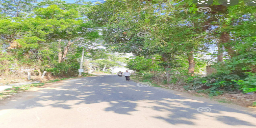

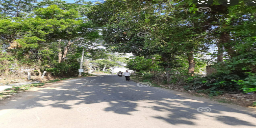

In [2]:
import time
image = cv2.imread('111.PNG')
image = cv2.resize(image,(256,128))
start = time.time()
result = gamma_correction(image)
end = time.time()
print(1/np.round((end-start),3),'fps')
cv2_imshow(result)
cv2_imshow(image)

14.492753623188404 fps


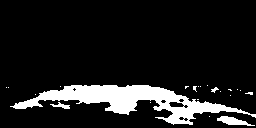

In [3]:
import time 
start = time.time()
image = cv2.imread('111.PNG')
image = cv2.resize(image,(256,128))
image_g = gamma_correction(image)
shadow = shadow_detection(image)
end = time.time()
print(1/np.round(end-start,3),'fps')
cv2_imshow(shadow)


90.90909090909092 fps


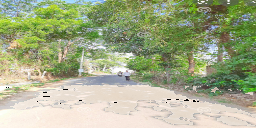

In [4]:
import time 
image = cv2.imread('111.PNG')
image = cv2.resize(image,(256,128))
start = time.time()
image_g = gamma_correction(image)
shadow = shadow_detection(image)
result = shadow_Compensation(shadow, image_g)
end = time.time()
print(1/np.round(end-start,3),'fps')
cv2_imshow(result)


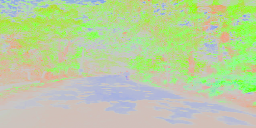

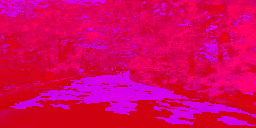

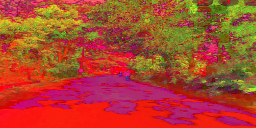

In [6]:
image = cv2.imread('111.PNG')
image = cv2.resize(image,(256,128))
image_g = gamma_correction(image)
c1c2c3 = BGR2c1c2c3(image_g)
cv2_imshow(c1c2c3*255)
hsv = cv2.cvtColor(c1c2c3*255, cv2.COLOR_BGR2HSV)
shadow = shadow_detection(image)
cv2_imshow(hsv)


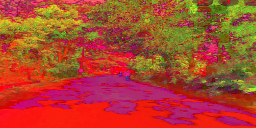

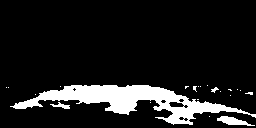

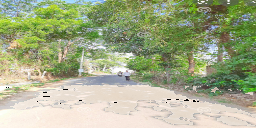

In [8]:
image = cv2.imread('111.PNG')
image = cv2.resize(image,(256,128))
image_g = gamma_correction(image)
hsv = cv2.cvtColor(image_g, cv2.COLOR_BGR2HSV)
cv2_imshow(hsv)
shadow = shadow_detection(image)
cv2_imshow(shadow)
result = shadow_Compensation(shadow, image_g)
cv2_imshow(result)
